### Create alongshore gaussian pulse wind stress file

* Find meridional and zonal contirbutions to get alongshore wind stress pulse, spatially uniform.
* Generate zonal and meridional wind files.
* Gaussian pulse, e-fold 6 hr (increases for the first 12 hr and decreases to 0 over the next 12 hr).

Domain 2 is bounded by

* north: 30.5 N 
* south: 27.0 N
* east: -116.0 W
* west -114.0 W

Grid
* Horizontal resolution: -0.015625 deg (~1.7 km, check!)
* nx=160, ny=224, nz=15, 
* N, W and S boundaries open

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
%matplotlib inline

### Make a 1D gaussian bump

In [21]:
# Gaussian pulse
t = np.linspace(0,60,120)
max_tau = 0.1 # base is 0.1 n/mˆ2
sigma = 3 # base is 6
center = 6 # base is 12
gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))

# half gaussian - abrupt stop
half_gauss = gauss.copy()
half_gauss[13:] = 0

Text(0, 0.5, '$\\tau_{||}$ / N m$^{-2}$')

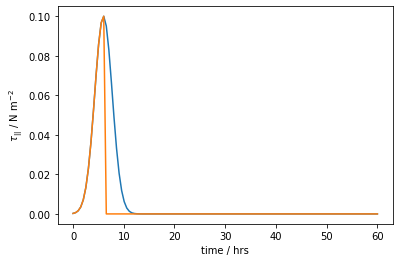

In [22]:
plt.plot(t,gauss)
plt.plot(t,half_gauss)

plt.xlabel('time / hrs')
plt.ylabel(r'$\tau_{||}$ / N m$^{-2}$')

### Find rotation angle to line up winds with shoreline

In [23]:
# Find rotation angle 
bathy_file = '/Users/Karina/Tools/MITgcm/SVB/coarse_160x224_OBCS/run01_upw_gauss/gridGlob.nc'

with Dataset(bathy_file, 'r') as nbl:
    lat = nbl.variables['Y'][:]
    lon = nbl.variables['X'][:]
    depth = nbl.variables['Depth'][:]

# Make 2D dummy constant winds
nx = 160
ny = 224
phi = np.linspace(27.0,30.5,ny)
tau_y = max_tau*np.ones_like(phi)
tauy_2d = np.expand_dims(tau_y,0) + np.zeros((nx,ny))

# Guess angle of rotation (120 alongshore downwelling winds, 300 alongshore upwelling winds )
alpha = np.radians(120.)
alpha2 = np.radians(300.)
u_mer = tauy_2d*np.sin(alpha)
u_zon = tauy_2d*np.cos(alpha)
u_mer2 = tauy_2d*np.sin(alpha2)
u_zon2 = tauy_2d*np.cos(alpha2)

/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/Users/Karina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: No contour levels were found within the data range.
  app.launch_new_instance()


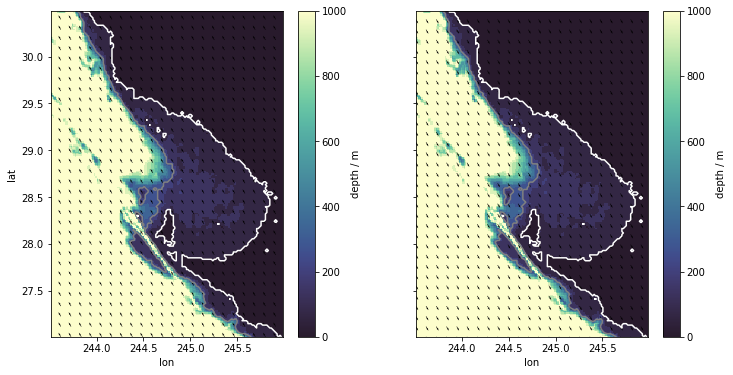

In [24]:
LON,LAT = np.meshgrid(lon,lat)

fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,6), sharey=True)
pc = ax.pcolormesh(lon,lat,depth, cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc, ax=ax)
cn2 = ax.contour(lon,lat,depth, colors='0.5', levels=[250])
cn2 = ax.contour(lon,lat,depth, colors='w', levels=[0])
ax.quiver(LON[::7,::7],LAT[::7,::7],u_zon[::7,::7],u_mer[::7,::7])
cb.set_label('depth / m')
ax.set_xlabel('lon')
ax.set_ylabel('lat')

pc2 = ax2.pcolormesh(lon,lat,depth, cmap=cmo.cm.deep_r)
cb2 = plt.colorbar(pc2, ax=ax2)
cn3 = ax2.contour(lon,lat,depth, colors='0.5', levels=[250])
cn3 = ax2.contour(lon,lat,depth, colors='w', levels=[0])
ax2.quiver(LON[::7,::7],LAT[::7,::7],u_zon2[::7,::7],u_mer2[::7,::7])
cb2.set_label('depth / m')
ax2.set_xlabel('lon')

ax.set_aspect(1)
ax2.set_aspect(1)

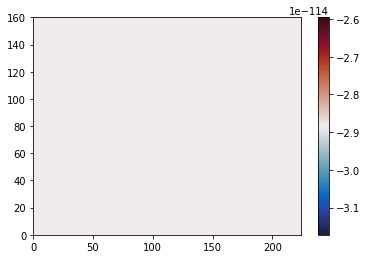

In [25]:
# Generate wind stress arrays - gaussian
nx = 160
ny = 224
nt = 120
windstress= np.expand_dims(np.expand_dims(gauss,0),0) + np.zeros((nx,ny,nt))

zonal_tau = windstress*np.cos(alpha)
merid_tau = windstress*np.sin(alpha)

zonal_tau2 = windstress*np.cos(alpha2)
merid_tau2 = windstress*np.sin(alpha2)

cm = plt.pcolormesh(zonal_tau[:,:,90], cmap=cmo.cm.balance)
plt.colorbar(cm)

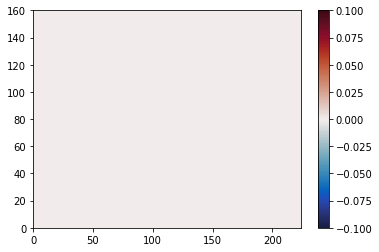

In [7]:
# Generate wind stress arrays - half gaussian
nx = 160
ny = 224
nt = 120
windstress_half= np.expand_dims(np.expand_dims(half_gauss,0),0) + np.zeros((nx,ny,nt))

zonal_tau_half = windstress_half*np.cos(alpha)
merid_tau_half = windstress_half*np.sin(alpha)

zonal_tau2_half = windstress_half*np.cos(alpha2)
merid_tau2_half = windstress_half*np.sin(alpha2)

cm = plt.pcolormesh(zonal_tau_half[:,:,90], cmap=cmo.cm.balance)
plt.colorbar(cm)

### Binary files

In [26]:
dt = np.dtype('>f8')  # float 64 big endian

wind_fname1 = '160x224/downwelling_merid_gauss12h_160x224.bin'
fileobj = open(wind_fname1, mode='wb')
dd=merid_tau.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname2 = '160x224/downwelling_zonal_gauss12h_160x224.bin'
fileobj = open(wind_fname2, mode='wb')
dd=zonal_tau.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname3 = '160x224/upwelling_zonal_gauss12h_160x224.bin'
fileobj = open(wind_fname3, mode='wb')
dd=zonal_tau2.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname4 = '160x224/upwelling_merid_gauss12h_160x224.bin'
fileobj = open(wind_fname4, mode='wb')
dd=merid_tau2.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

In [9]:
dt = np.dtype('>f8')  # float 64 big endian

wind_fname1 = '160x224/downwelling_merid_halfgauss1d_160x224.bin'
fileobj = open(wind_fname1, mode='wb')
dd=merid_tau_half.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname2 = '160x224/downwelling_zonal_halfgauss1d_160x224.bin'
fileobj = open(wind_fname2, mode='wb')
dd=zonal_tau_half.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname3 = '160x224/upwelling_zonal_halfgauss1d_160x224.bin'
fileobj = open(wind_fname3, mode='wb')
dd=zonal_tau2_half.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname4 = '160x224/upwelling_merid_halfgauss1d_160x224.bin'
fileobj = open(wind_fname4, mode='wb')
dd=merid_tau2_half.transpose((2,0,1))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

#### Check that bin file works when read by fortran

(4300800,)


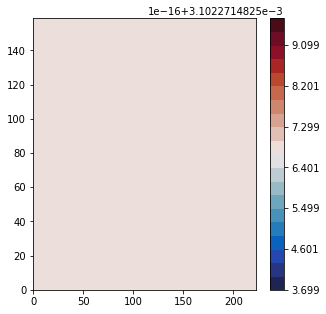

In [27]:
cc=np.fromfile(wind_fname3, dtype=dt)
print(np.shape(cc))

bF=np.reshape(cc,[nx,ny,nt],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.contourf(bF[:,:,20], 20, cmap=cmo.cm.balance)
plt.colorbar(pc,ax=ax)


In [11]:
LON

NameError: name 'LON' is not defined